In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
!git clone https://github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 219 (delta 123), reused 168 (delta 85), pack-reused 0
Receiving objects: 100% (219/219), 2.68 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import sys
from cxlayers import ImageToElectricField, CxMO, AngularSpectrum, CxD2NNIntensity, D2NNMNISTDetector, ImageResizing, D2NNMNISTFilter, CxD2NNFaradayRotation, GGG, ImageBinarization, Polarizer
import os
import matplotlib_style
import glob
import re
import datetime

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

# 単一モデル評価

## モデル読み込み

In [ ]:
path = 'trained_model/20220425_5'
model = tf.keras.models.load_model(path)
model.summary()

## 正解率

In [ ]:
history = pd.read_csv(path + '/history.csv')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, history.index.stop + 1), history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, history.index.stop + 1), history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

# model.evaluate(x_test, y_test)

## 混同行列

In [ ]:
pred_label = tf.argmax(model.predict(x_test), axis=-1).numpy()
cm = tf.math.confusion_matrix(y_test, pred_label)
label_tot = np.sum(cm, axis=1).reshape(-1, 1)
norm_cm = cm/label_tot

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(norm_cm, square=True, cbar=False, annot=True, fmt=".2f", cmap='BuPu')
plt.rcParams["font.size"] = 13
plt.xlabel("Predicted label", fontsize=13)
plt.ylabel("True label", fontsize=13)
plt.title("Normalized confusion matrix")

## 位相変調層

In [ ]:
pattern = r'cx_mo'
mo_layers = []
save = False
each_save = True
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        mo_layers.append(layer)

fig, axes = plt.subplots(1, len(mo_layers), figsize=(4 * len(mo_layers), 4))
for i, ax in enumerate(axes):
    layer = mo_layers[i]
    vmax = layer.limitation_num.numpy()
    vmin = -layer.limitation_num.numpy()
    im = ax.imshow(layer.get_limited_phi(),
              cmap="viridis",
              interpolation=None,
              vmin=vmin, vmax=vmax)
    ax.grid(False)
    ax.set_xticks([],color="None")
    ax.set_yticks([],color="None")

    if each_save:
        t_delta = datetime.timedelta(hours=9)
        JST = datetime.timezone(t_delta, 'JST')
        now = datetime.datetime.now(JST)
        plt.imsave('images/' + now.strftime('%Y%m%d%H%M%S') +"_" + str(i) + '.png',
                    layer.get_limited_phi(),
                    cmap="cividis",
                    vmin=vmin, vmax=vmax,
                    dpi=300)



if save:
    t_delta = datetime.timedelta(hours=9)
    JST = datetime.timezone(t_delta, 'JST')
    now = datetime.datetime.now(JST)
    fig.savefig('images/' + now.strftime('%Y%m%d%H%M%S') + '.png',
                dpi=300)

## 出力プロット

In [ ]:
layer_name = model.layers[-3].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num + 0, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output")
        axes[i, 2].set_title("Filtered Output")
        axes[i, 3].set_title("Predict")
        
fig.tight_layout()

## 途中出力可視化

### 光強度

In [ ]:
plt.rcParams["font.size"] = 20
output_class = CxD2NNIntensity
pattern = r'angular_spectrum'
outputs = [model.layers[2].output]
each_save = False
save = False
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        outputs.append(output_class((100, 100))(layer.output))
# outputs.pop(-2)
outputs.append(D2NNMNISTFilter((100, 100))(model.layers[-3].output))
outputs.append(model.layers[-1].output)
hidden_layer_model = tf.keras.Model(model.inputs, outputs=outputs)
images_num = 2
# intput_images = x_test[0:images_num,:,:]
input_images = np.array([x_test[1,:,:], x_test[0,:,:]])
pred = hidden_layer_model.predict(input_images)
fig, axes = plt.subplots(images_num, len(pred), figsize=(4 * len(pred), 4 * images_num))
for i, _ax in enumerate(axes):
    for j, ax in enumerate(_ax):
        if j==len(pred)-1:
            ax.bar(np.arange(0, 10, 1), pred[j][i, :], align='center')
            ax.set_xticks(np.arange(0, 10, 1))
            ax.set_ylim(0, 1)
            ax.grid(False)
            ax.set_xlabel("Label")
            ax.set_ylabel("Expected probability")
            ax.spines['top'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.set_facecolor('white')
            ax_pos = axes[i,j-1].get_position()
            ax.set_position([0.84, ax_pos.y0, ax_pos.width, ax_pos.height])
            ax.yaxis.set_label_position("right")

            ax.tick_params(labelright=True, labelleft=False)
            axpos = axes[i,j-1].get_position()
            cbar_ax = fig.add_axes([0.805, axpos.y0, 0.005, axpos.height])
            cbar = fig.colorbar(axes[i, j-1].images[0], cax=cbar_ax, label='Normalized intensity (a.u)')

            # divider = make_axes_locatable(axes[i,j-1]) #axに紐付いたAxesDividerを取得
            # cax = divider.append_axes("right", size="5%", pad=0.1) #append_axesで新しいaxesを作成
            # fig.colorbar(axes[i,j-1].images[0], cax=cax, label='Normalized Intensity')

        else:
            image = pred[j][i,:,:]
            norm_image = image / np.max(image)
            ax_im = ax.imshow(norm_image, cmap="viridis", interpolation=None, vmin=0., vmax=1.)
            # divider = make_axes_locatable(ax) #axに紐付いたAxesDividerを取得
            # cax = divider.append_axes("right", size="5%", pad=0.1) #append_axesで新しいaxesを作成
            # fig.colorbar(ax_im, cax=cax) #新しく作成したaxesであるcaxを渡す。
            ax.grid(False)
            ax.set_xticks([],color="black")
            ax.set_yticks([],color="black")

        if each_save:
            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig('images/' + "image_" + str(i) + "_" + str(j) + ".png", bbox_inches=extent)


if save:
    t_delta = datetime.timedelta(hours=9)
    JST = datetime.timezone(t_delta, 'JST')
    now = datetime.datetime.now(JST)
    fig.savefig('images/' + now.strftime('%Y%m%d%H%M%S') + '.png', dpi=300)

In [ ]:
plt.rcParams["font.size"] = 22
fig, axes = plt.subplots(images_num, len(pred), figsize=(4 * len(pred), 4 * images_num))
fig.subplots_adjust(wspace=0.5, hspace=0.2)
for _ax in axes:
    for ax in _ax:
        ax.grid(False)
        ax.set_xticks([],color="none")
        ax.set_yticks([],color="none")

for j in range(2):
    for i in range(7):
        norm_image = pred[i][j,:,:] / np.max(pred[i][j,:,:])
        axes[j, i].imshow(norm_image, cmap='viridis', vmin=0., vmax=1.)

    axes[j, 6].tick_params(labelright=True, labelleft=False)
    axpos = axes[j,6].get_position()
    cbar_ax = fig.add_axes([0.805, axpos.y0, 0.005, axpos.height])
    cbar = fig.colorbar(axes[j, 6].images[0], cax=cbar_ax, label='Normalized intensity (a.u)')

    axes[j, 6].text(12,20, "0", color="white")
    axes[j, 6].text(46,20, "1", color="white")
    axes[j, 6].text(78,20, "2", color="white")
    axes[j, 6].text(12,43, "3", color="white")
    axes[j, 6].text(35,43, "4", color="white")
    axes[j, 6].text(56.5,43, "5", color="white")
    axes[j, 6].text(78,43, "6", color="white")
    axes[j, 6].text(12,64, "7", color="white")
    axes[j, 6].text(46,64, "8", color="white")
    axes[j, 6].text(78,64, "9", color="white")

    # fig.colorbar(axes[0, 6].images[0], ax=axes[0, 6], label='Normalized intensity (a.u)')

    axes[j, 7].bar(np.arange(0, 10, 1), pred[7][j, :], align='center')
    axes[j, 7].set_xticks(np.arange(0, 10, 1))
    axes[j, 7].set_ylim(0, 1)
    axes[j, 7].grid(False)
    axes[j, 7].set_xlabel("Label")
    axes[j, 7].set_ylabel("Expected probability")
    axes[j, 7].spines['top'].set_color('black')
    axes[j, 7].spines['bottom'].set_color('black')
    axes[j, 7].spines['left'].set_color('black')
    axes[j, 7].spines['right'].set_color('black')
    axes[j, 7].set_facecolor('white')
    axes[j, 7].yaxis.set_label_position("right")
    axes[j, 7].tick_params(labelright=True, labelleft=False)
    ax_pos = axes[j,6].get_position()
    axes[j, 7].set_position([0.85, ax_pos.y0, ax_pos.width, ax_pos.height])

fig.savefig("images/test2.png", dpi=300)

### ファラデー回転角

In [ ]:
output_class = CxD2NNFaradayRotation
pattern = r'angular_spectrum'
outputs = [model.layers[2].output]
each_save = False
save = True
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        outputs.append(output_class((100, 100))(layer.output))
phi = model.layers[4].limitation_num.numpy()
outputs.append(D2NNMNISTFilter((100, 100))(model.layers[-3].output))
outputs.append(model.layers[-1].output)
hidden_layer_model = tf.keras.Model(model.inputs, outputs=outputs)
images_num = 2
input_images = x_test[0:images_num,:,:]
input_images = np.array([x_test[1,:,:], x_test[0,:,:]])
pred = hidden_layer_model.predict(input_images)
fig, axes = plt.subplots(images_num, len(pred), figsize=(4 * len(pred), 4 * images_num))
fig.subplots_adjust(wspace=0.35, hspace=1)
for i, _ax in enumerate(axes):
    for j, ax in enumerate(_ax):
        if j==0:
            image = pred[j][i,:,:]
            ax_im = ax.imshow(image/np.max(image), cmap="viridis", interpolation=None)
            ax.grid(False)
            ax.set_xticks([],color="black")
            ax.set_yticks([],color="black")
            divider = make_axes_locatable(ax) #axに紐付いたAxesDividerを取得
            cax = divider.append_axes("right", size="5%", pad=0.1) #append_axesで新しいaxesを作成
            cbar = fig.colorbar(ax_im, cax=cax) #新しく作成したaxesであるcaxを渡す。
            cbar.set_label('Normalized Intensity (a.u.)')
        elif j==len(pred)-1:
            rect = ax.bar(np.arange(0, 10, 1), pred[j][i, :], align='center')
            max_idx = np.argmax(pred[j][i, :])
            rect[max_idx].set_color("red")
            ax.set_xticks(np.arange(0, 10, 1))
            ax.set_ylim(0, 1)
            ax.grid(False)
            ax.set_xlabel("Label")
            ax.set_ylabel("Expected probability")
            ax.spines['top'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.set_facecolor('white')
            ax_pos = axes[i,j-1].get_position()
            ax.set_position([0.87, ax_pos.y0, ax_pos.width, ax_pos.height])
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()

            # ax.tick_params(labelright=True, labelleft=False)
            # axpos = axes[i,j-1].get_position()
            # cbar_ax = fig.add_axes([0.805, axpos.y0, 0.005, axpos.height])
            # cbar = fig.colorbar(axes[i, j-1].images[0], cax=cbar_ax, label='Normalized intensity (a.u)')

            # divider = make_axes_locatable(axes[i,j-1]) #axに紐付いたAxesDividerを取得
            # cax = divider.append_axes("right", size="5%", pad=0.1) #append_axesで新しいaxesを作成
            # fig.colorbar(axes[i,j-1].images[0], cax=cax, label='Normalized Intensity')

        else:
            image = pred[j][i,:,:]
            ax_im = ax.imshow(image, cmap="viridis", interpolation=None, vmin=-phi*j-0.001, vmax=phi*j+0.001)
            divider = make_axes_locatable(ax) #axに紐付いたAxesDividerを取得
            cax = divider.append_axes("right", size="5%", pad=0.1) #append_axesで新しいaxesを作成
            cbar = fig.colorbar(ax_im, cax=cax, ticks=[-phi*j, 0, phi*j]) #新しく作成したaxesであるcaxを渡す。
            cbar.ax.set_ylim(-phi*j, phi*j)
            if j==1:
                ticklabel = [r'$\dfrac{-\pi}{100}$', '0.0', r'$\dfrac{\pi}{100}$']
            elif j==6:
                ticklabel = [r'$\dfrac{-5\pi}{100}$', '0.0', r'$\dfrac{5\pi}{100}$']
                cbar.set_label('Faraday rotation (rad.)')
                ax.text(12,20, "0", color="white")
                ax.text(46,20, "1", color="white")
                ax.text(78,20, "2", color="white")
                ax.text(12,43, "3", color="white")
                ax.text(35,43, "4", color="white")
                ax.text(56.5,43, "5", color="white")
                ax.text(78,43, "6", color="white")
                ax.text(12,64, "7", color="white")
                ax.text(46,64, "8", color="white")
                ax.text(78,64, "9", color="white")
            else:
                ticklabel = [r'$\dfrac{-' + str(j) + '\pi}{100}$', '0.0', r'$\dfrac{' + str(j) + '\pi}{100}$']
            cbar.ax.set_yticklabels(ticklabel)
            ax.grid(False)
            ax.set_xticks([],color="black")
            ax.set_yticks([],color="black")

        if each_save:
            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig('images/' + "image_" + str(i) + "_" + str(j) + ".png", bbox_inches=extent)

# fig.tight_layout()
# fig.canvas.draw()
pos = axes[0, 0].get_position()
axes[0, 0].set_position([0.12, pos.y0, pos.width, pos.height])

pos = axes[1, 0].get_position()
axes[1, 0].set_position([0.12, pos.y0, pos.width, pos.height])

pos = axes[0, -1].get_position()
axes[0, -1].set_position([pos.x0-0.025, pos.y0, pos.width-0.01, pos.height])

pos = axes[1, -1].get_position()
axes[1, -1].set_position([pos.x0-0.025, pos.y0, pos.width-0.01, pos.height])


if save:
    t_delta = datetime.timedelta(hours=9)
    JST = datetime.timezone(t_delta, 'JST')
    now = datetime.datetime.now(JST)
    fig.savefig('images/' + now.strftime('%Y%m%d%H%M%S') + '.png', dpi=300)

## 2値化して出力プロット

In [ ]:
mo_layer_index = [4, 6]
limit_value = 2.1 * np.pi / 180
for idx in mo_layer_index:
    phi = model.layers[idx].get_weights()
    phi_lim = tf.tanh(phi)
    phi_bi = tf.where(phi_lim >= 0, limit_value, -limit_value)
    model.layers[idx].set_weights(phi_bi)
    model.layers[idx].limitation=None

layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('Accuracy')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
fig.tight_layout()

In [ ]:
model.evaluate(x_test, y_test)

## 位相変調量

In [ ]:
bi_phase = model.layers[5].get_weights()[0]
plt.imshow(bi_phase, cmap='plasma', interpolation='none')
plt.colorbar()
bi_phase = np.where(bi_phase >= 0, 1, -1)
np.savetxt('data/phase/20220319-1/layer2.csv', bi_phase, fmt='%d', delimiter=',')

## 学習過程の正解率比較

In [ ]:
path = 'trained_model'
files = glob.glob(path + '/20220317*/history.csv')
labels = [r'$\pm 90\degree$', r'$\pm 45 \degree$', r'$\pm 10 \degree$']
for i, file in enumerate(files):
    history = pd.read_csv(file)
    plt.plot(range(1, history.index.stop + 1), history['accuracy'], label=labels[i])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("epoch")

In [ ]:
testmodel.layers[6].set_weights(2.1*np.pi/180*tf.tanh(model.layers[6].get_weights()))

In [ ]:
testmodel.layers[-3].phi

In [ ]:
testmodel.evaluate(x_test, y_test)

# 複数モデル比較

## 学習経過

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220424_*/*.csv"
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=True, key=lambda s: int(p.search(s).group()))
plt.figure(figsize=(7, 4))
lines = []
for i, file in enumerate(files[6:12]):
    result = pd.read_csv(file)
    lines.append(plt.plot(result["val_accuracy"], label=label[i]))

plt.legend(title=r'$\Delta \phi$', loc='upper left', bbox_to_anchor=(1, 1))
plt.yticks(np.arange(0, 1.1, 0.1), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel("Accuracy")
plt.xlabel("Epoch Number")
plt.tight_layout()

## 出力

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220410_*"
files = glob.glob(path)
files.sort()

input_images = x_train[0:2,:,:]
fig, axes = plt.subplots(len(files), 4, figsize=(len(files)*3, 4*3))
for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    output_layer_name = model.layers[-3].name
    output_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(output_layer_name).output)
    filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(output_layer_name).output)
    filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

    output_images = output_layer_model.predict(input_images)
    filtered_images = filter_model.predict(input_images)
    pred = model.predict(input_images)

    axes[i, 0].imshow(images[0, :, :])
    axes[i, 1].imshow(output_images[0, :, :])
    axes[i, 2].imshow(filtered_images[0,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), pred[0, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output Intensity")
        axes[i, 2].set_title("Filtered Intensity")
        axes[i, 3].set_title("Predict")

fig.tight_layout()

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220415_*"
files = glob.glob(path)
files.sort()
print(files)

for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    print(model.layers[-4].get_weights()[0] * 180 / np.pi)

fig.tight_layout()

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220410_*"
files = glob.glob(path)
files.sort()

input_images = x_train[0:2,:,:]
fig, axes = plt.subplots(len(files), 4, figsize=(len(files)*3, 4*3))
for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    output_layer_name = model.layers[-3].name
    output_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(output_layer_name).output)
    filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(output_layer_name).output)
    filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

    output_images = output_layer_model.predict(input_images)
    filtered_images = filter_model.predict(input_images)
    pred = model.predict(input_images)

    axes[i, 0].imshow(images[0, :, :])
    axes[i, 1].imshow(output_images[0, :, :])
    axes[i, 2].imshow(filtered_images[0,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), pred[0, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output Intensity")
        axes[i, 2].set_title("Filtered Intensity")
        axes[i, 3].set_title("Predict")

fig.tight_layout()

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220415_*"
files = glob.glob(path)
files.sort()
print(files)

for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    print(model.layers[-4].get_weights()[0] * 180 / np.pi)

fig.tight_layout()

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220410_*"
files = glob.glob(path)
files.sort()

input_images = x_train[0:2,:,:]
fig, axes = plt.subplots(len(files), 4, figsize=(len(files)*3, 4*3))
for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    output_layer_name = model.layers[-3].name
    output_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(output_layer_name).output)
    filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(output_layer_name).output)
    filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

    output_images = output_layer_model.predict(input_images)
    filtered_images = filter_model.predict(input_images)
    pred = model.predict(input_images)

    axes[i, 0].imshow(images[0, :, :])
    axes[i, 1].imshow(output_images[0, :, :])
    axes[i, 2].imshow(filtered_images[0,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), pred[0, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output Intensity")
        axes[i, 2].set_title("Filtered Intensity")
        axes[i, 3].set_title("Predict")

fig.tight_layout()

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220415_*"
files = glob.glob(path)
files.sort()
print(files)

for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    print(model.layers[-4].get_weights()[0] * 180 / np.pi)

fig.tight_layout()

2022-04-12 11:18:49.708386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:49.917799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:50.144720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:50.749098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:50.961645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:51.172517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:51.766477: I tensorflow/core/grappler/optimizers/cust

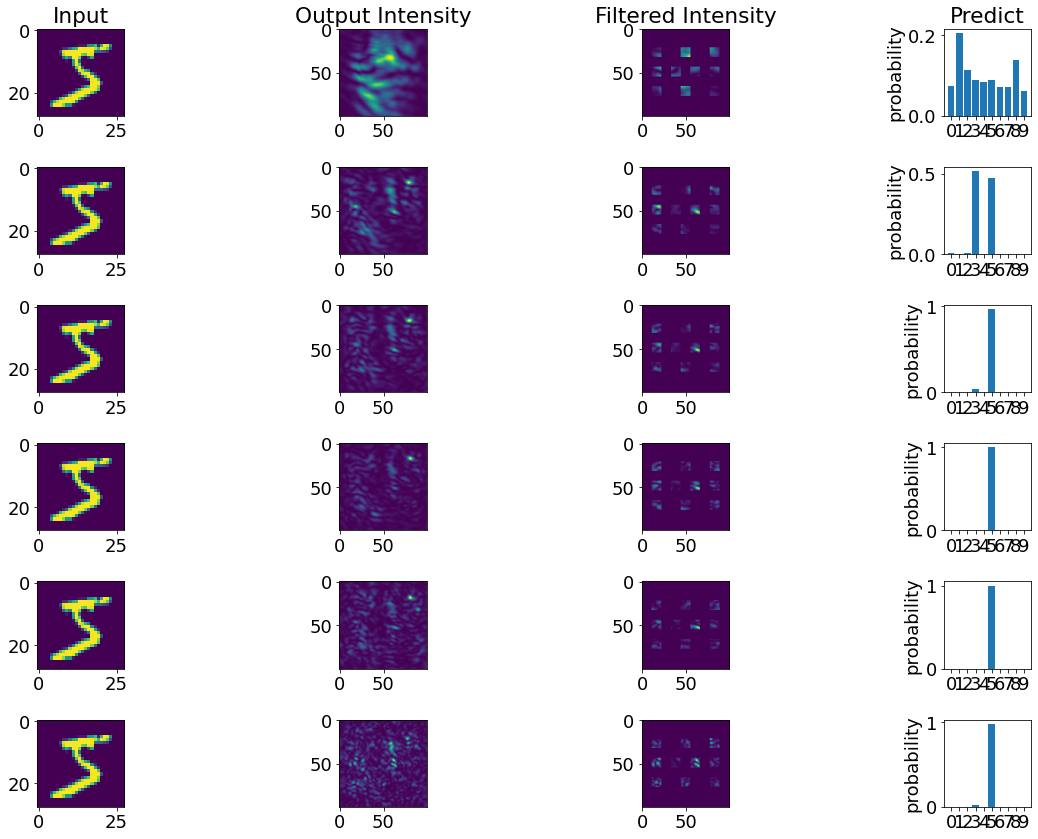

In [17]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220410_*"
files = glob.glob(path)
files.sort()

input_images = x_train[0:2,:,:]
fig, axes = plt.subplots(len(files), 4, figsize=(len(files)*3, 4*3))
for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    output_layer_name = model.layers[-3].name
    output_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(output_layer_name).output)
    filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(output_layer_name).output)
    filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

    output_images = output_layer_model.predict(input_images)
    filtered_images = filter_model.predict(input_images)
    pred = model.predict(input_images)

    axes[i, 0].imshow(images[0, :, :])
    axes[i, 1].imshow(output_images[0, :, :])
    axes[i, 2].imshow(filtered_images[0,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), pred[0, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output Intensity")
        axes[i, 2].set_title("Filtered Intensity")
        axes[i, 3].set_title("Predict")

fig.tight_layout()

['trained_model/20220415_1', 'trained_model/20220415_2', 'trained_model/20220415_3', 'trained_model/20220415_4', 'trained_model/20220415_5', 'trained_model/20220415_6']
Metal device set to: Apple M1


2022-04-18 15:11:31.551374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-18 15:11:31.551632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


80.64450115301494
79.81873811254957
70.09541741390282
63.01641128261567
58.06893643656026
50.4132881695002


NameError: name 'fig' is not defined